<a href="https://colab.research.google.com/github/claudiosegala/Monografia/blob/master/code/tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC

## Models

- Random Guess
- Mean
- Random Forest
- RNN
- LSTM
- GRU

## Evaluation

- RMSE
- NRMSE
  - Normalized by stardartization

# Mount Drive

Connect to Google Drive of 'alfredcoinworth'

In [47]:
import google as g # To connect with google drive
g.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Dependencies

In this phase we have to download all the dependencies that our code will need

In [48]:
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install sklearn
!pip install keras
!pip install statsmodels

# Define headers

In this phase we have to declare all the libraries that we will use.

In [0]:
import tensorflow as tf # machine learning library
import pandas as pd # data manipulation library
import matplotlib.pyplot as plt # plot library
import numpy as np # math library
import datetime as dt # to discover week day
import time as tm # to convert to seconds
import sklearn as skl # regression templates library
import sklearn.metrics as sklm # metrics
import statsmodels.api as sma # statistical models api
import statistics as st # statistics
import statsmodels as sm # statistical models

# Configurations

Diminish the verbosity of tensorflow

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)

# Configure Hyperparameters

In [0]:
TRAIN_SPLIT = 0.8

SEEABLE_PAST = 100 # in minutes

PREDICT_IN_FUTURE = 15 # in minutes

FLOW_INTERVAL = 150 # the interval size for each flow

MULTIVARIATE = False # if we are gonna use multiple data or not

# Derivated

N_STEPS = SEEABLE_PAST * 60 // FLOW_INTERVAL # the number of flows to see in the past

N_FUTURE = PREDICT_IN_FUTURE * 60 // FLOW_INTERVAL # how much in the future we want to predict (0 = predict the flow on the next 5 minutes)

N_FEATURES = 9 if MULTIVARIATE else 1

DAY_SIZE = (24 * 3600) // FLOW_INTERVAL  

WEEK_SIZE = 7 * DAY_SIZE

# Data Retrieval

This phase we have to get the data stored in Google Drive.


In [0]:
col_names = ['Sensor', 'Date', 'Time', 'Lane', 'Speed', 'Max Speed', 'Size']
all_data = pd.read_csv('/content/drive/My Drive/TCC/chunks/all_data_sorted.csv', ';', header=None, names=col_names)

In [53]:
all_data.head()

,Sensor,Date,Time,Lane,Speed,Max Speed,Size
0,RSI128,2016/05/01,00:00:09,1,26.0,60.0,0.0
1,RSI131,2016/05/01,00:00:09,2,20.0,60.0,1.1
2,RSI132,2016/05/01,00:00:09,1,45.0,60.0,0.0
3,RSI131,2016/05/01,00:00:10,1,40.0,60.0,0.5
4,RSI129,2016/05/01,00:00:12,1,35.0,60.0,0.0


# Data Pre-processing



In [0]:
def adjust_data(data):
  # Extract data from just one sensor
  data = data[data['Sensor'] == 'RSI128']
  
  # Remove unnecessary columns
  data = data.drop(columns=['Sensor','Lane','Max Speed','Size'])
   
  # Adjust type
  data['Time'] = data['Time'].apply(lambda x : tm.strptime(x, '%H:%M:%S'))
  data['Time'] = data['Time'].apply(lambda x : dt.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds())
  data['Time'] = data['Time'].apply(lambda x : int(x))
  data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
  data['Speed'].apply(lambda x : float(x))
  
  # Create week day from date
  data['WeekDay'] = data['Date'].apply(lambda x : x.weekday())
  
  return data

In [0]:
data = adjust_data(all_data)

In [56]:
data.head()

,Date,Time,Speed,WeekDay
0,2016-05-01,9,26.0,6
7,2016-05-01,18,32.0,6
39,2016-05-01,104,16.0,6
108,2016-05-01,206,22.0,6
160,2016-05-01,305,25.0,6


In [57]:
data.describe()

,Time,Speed,WeekDay
count,536879.000000,536879.000000,536879.000000
mean,51715.214387,31.078891,2.951632
std,17952.214406,7.168803,1.959146
min,3.000000,2.000000,0.000000
25%,38412.500000,26.000000,1.000000
50%,52364.000000,31.000000,3.000000
75%,65757.000000,35.000000,5.000000
max,86399.000000,67.000000,6.000000


In [58]:
print(f"This data is from <{data['Date'].min()}> to <{data['Date'].max()}>\n")

print(f"It contains {len(data['Date'])} entries\n")

for col, cont in data.iteritems():
    print(f"Column {col} has {cont.isnull().sum()} null elements and {cont.isna().sum()} nan elements")

This data is from <2016-05-01 00:00:00> to <2016-07-31 00:00:00>

It contains 536879 entries

Column Date has 0 null elements and 0 nan elements
Column Time has 0 null elements and 0 nan elements
Column Speed has 0 null elements and 0 nan elements
Column WeekDay has 0 null elements and 0 nan elements


# Flow Retrieval

This will transform the time series of register cars that passed in a array of flow per k minute.

In [0]:
def get_flow_data(n, accSpeed, weekDay):
  avgSpeed = accSpeed // n if n else 0
  wd = [1 if weekDay == i else 0 for i in range(7)] # weekday
  
  return (n, avgSpeed, wd[0], wd[1], wd[2], wd[3], wd[4], wd[5], wd[6])

In [0]:
def get_flow (data):
  date = np.asarray(data['Date'])
  weekDay = np.asarray(data['WeekDay'])
  time = np.asarray(data['Time'])
  speed = np.asarray(data['Speed'])
  
  dateControl = date[0] #seta o controle de data com o primeiro dia do chunk
  timeBlock = FLOW_INTERVAL
  countFlow = 0
  accSpeed = 0
  flowData = []

  for i in range(len(date)):
    if time[i] >= timeBlock: # init a new time block
      flowData.append(get_flow_data(countFlow, accSpeed, weekDay[i])) 
      timeBlock += FLOW_INTERVAL
      accSpeed = 0
      countFlow = 0
      
    if date[i] > dateControl: # reset on day change
      dateControl = date[i]
      timeBlock = FLOW_INTERVAL 
      countFlow = 0
      accSpeed = 0
      
    if time[i] < timeBlock: # add car on flow
      countFlow += 1
      accSpeed += speed[i]
      
  flowDataColumns = ['Flow', 'AverageSpeed', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
  flowData = pd.DataFrame(flowData, columns=flowDataColumns) 
  
  return flowData

In [0]:
multivariateData = get_flow(data)
univariateData = multivariateData['Flow']

In [62]:
multivariateData.describe()

,Flow,AverageSpeed,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
count,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000
mean,9.935649,23.848555,0.141312,0.141293,0.141312,0.141312,0.141312,0.141312,0.152145
std,8.453318,13.100536,0.348347,0.348327,0.348347,0.348347,0.348347,0.348347,0.359165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,66.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
univariateData.describe()

count    52897.000000
mean         9.935649
std          8.453318
min          0.000000
25%          2.000000
50%          9.000000
75%         17.000000
max         41.000000
Name: Flow, dtype: float64

# Flow Analysis

This is based on [A Guide to Time Series Visualization with Python 3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3).



[]

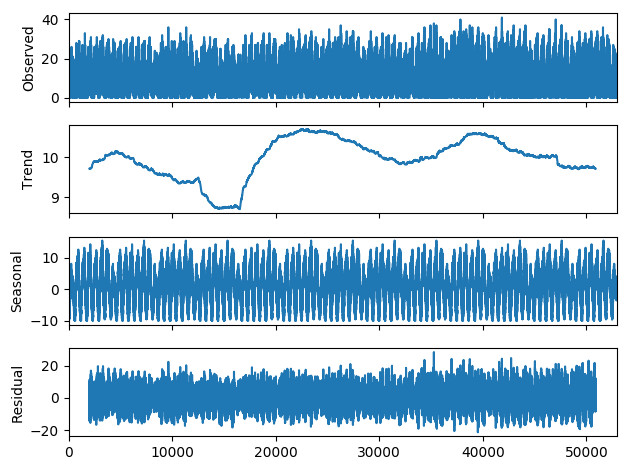

In [64]:
decomposition = sm.tsa.seasonal.seasonal_decompose(univariateData, model='additive', freq=WEEK_SIZE)
fig = decomposition.plot()

plt.rcdefaults()
plt.plot()

# Prepare Dataset

This phase will form the input (X) and the output (Y)

In [0]:
# split_sequence([1, 2, 3, 4, 5], 3) #=> ([[1, 2, 3], [2, 3, 4]], [4, 5])
def split_sequence(sequence):
  n = len(sequence)
  X, Y = list(), list()
  
  for i in range(n):
    # find the end of this pattern
    end_ix = i + N_STEPS

    # check if we are beyond the sequence
    if end_ix + N_FUTURE > n-1:
      break

    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + N_FUTURE]
    X.append(seq_x)
    Y.append(seq_y[0] if MULTIVARIATE else seq_y)

  return np.array(X), np.array(Y)

In [0]:
def reshape_flow (raw_seq):  
  # split into samples
  X, Y = split_sequence(raw_seq)

  # reshape from [samples, timesteps] into [samples, timesteps, features]
  X = X.reshape((X.shape[0], X.shape[1], N_FEATURES))
  
  return X, Y

In [0]:
X, Y = reshape_flow(multivariateData if MULTIVARIATE else univariateData)

In [68]:
print(X.shape)

(52851, 40, 1)


In [69]:
print(Y.shape)

(52851,)


# Util


In [0]:
from keras.models import Sequential
from keras.layers import Dense

In [0]:
def split (n, window_size, test_split):
  test_size = int(window_size * test_split)
  jump_size = test_size
  train_size = window_size - test_size
  
  i, j, k = 0, train_size, min(n, train_size + test_size)
  
  res = []
  
  while j < n:
    res.append((i, j, k))
    
    i = i + jump_size
    j = i + train_size
    k = min(n, j + test_size)
    
  return res

In [0]:
def evaluate (expected, observed, times, verbose=0):
  n = len(expected)
  RMSE = [0] * n
  NRMSE = [0] * n
  MAE = [0] * n
  
  for i in range(n):
    Y = expected[i]
    Y_hat = observed[i]
    time = times[i]
    
    MAE[i] = sklm.mean_absolute_error(Y, Y_hat)
    RMSE[i] = np.sqrt(sklm.mean_squared_error(Y, Y_hat))
    NRMSE[i] = RMSE[i] / np.std(Y)
    
    if verbose >= 0:
      print(f"({i+1}/{n}) Test Size: {len(Y)}, Time: {time}s, RMSE: {RMSE[i]}, NRMSE: {NRMSE[i]}, MAE: {MAE[i]}")
      
  if verbose >= 0:
    flatten = lambda l: [i for sl in l for i in sl]
    plot_prediction(flatten(expected), flatten(observed))
      
  time = sum(times)
  rmse = sum(RMSE) / n
  nrmse = sum(NRMSE) / n
  mae = sum(MAE) / n
  
  return (time, rmse, nrmse, mae)

In [0]:
results = {}

# Baseline: Random

This implementation just guess a random number in the [0, 100] interval for every output.

In [0]:
import random as rnd # random

In [0]:
def random_guess (Y):
  m = max(Y)
  
  expected, observed, times = [], [], []
  pointers = split(len(X), 20000, 0.25)
  
  for i, j, k in pointers:
    start = tm.time()
    
    expected.append(Y[j:k])
    observed.append([rnd.randint(0, m) for i in range(k - j)])
    times.append(tm.time() - start)
    
  return evaluate(expected, observed, times, 1)

# Baseline: Default

This implementation just get the mean of every flow value in the input and place it as output.

In [0]:
def default_mean (X, Y):
  expected, observed, times = [], [], []
  pointers = split(len(X), 20000, 0.25)
  
  for i, j, k in pointers:
    start = tm.time()
    
    expected.append(Y[j:k])
    observed.append([np.mean([v[0] for v in x]) for x in X[j:k]])
    times.append(tm.time() - start)
    
  return evaluate(expected, observed, times)

# Random Forest

This implementation is based on [Random Forest Algorithm with Python and Scikit-Learn](https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/)

In [0]:
from sklearn.ensemble.forest import RandomForestRegressor

In [0]:
def random_forest(X, Y):
  model = skl.ensemble.RandomForestRegressor(n_estimators=100, max_features='auto', random_state=0)

  expected, observed, times = [], [], []
  pointers = split(len(X), 20000, 0.25)
  
  X = X.reshape(X.shape[0], X.shape[1])
  
  for i, j, k in pointers:
    start = tm.time()
    
    model.fit(X[i:j], Y[i:j])
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
  return evaluate(expected, observed, times)

# Support Vector Machine

In [0]:
from sklearn import svm

In [0]:
def support_vector_machine(X,Y):
  model = svm.SVR(gamma='scale', C=1.0, epsilon=0.2)

  expected, observed, times = [], [], []
  pointers = split(len(X), 20000, 0.25)
  
  for i, j, k in pointers:
    start = tm.time()
    
    model.fit(X[i:j], Y[i:j])
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
  return evaluate(expected, observed, times)

# RNN

In [0]:
from keras.layers import SimpleRNN

In [0]:
def rnn (X, Y): 
  model = Sequential()
  
  model.add(SimpleRNN(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(Dense(1))
  
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  expected, observed, times = [], [], []
  pointers = split(len(X), 20000, 0.25)
  
  for i, j, k in pointers:
    start = tm.time()
    
    model.fit(X[i:j], Y[i:j], validation_split=0.2, batch_size=64, epochs=15, verbose=0)
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
  return evaluate(expected, observed, times)

# LSTM

In [0]:
from keras.layers import LSTM

In [0]:
def lstm (X, Y): 
  model = Sequential()
  
  model.add(LSTM(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(Dense(1))
  
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  expected, observed, times = [], [], []
  pointers = split(len(X), 20000, 0.25)
  
  for i, j, k in pointers:
    start = tm.time()
    
    model.fit(X[i:j], Y[i:j], validation_split=0.2, batch_size=64, epochs=15, verbose=0)
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
  return evaluate(expected, observed, times)

# GRU

In [0]:
from keras.layers import GRU

In [0]:
def gru (X, Y): 
  model = Sequential()
  
  model.add(GRU(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(Dense(1))
  
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])

  expected, observed, times = [], [], []
  pointers = split(len(X), 20000, 0.25)
  
  for i, j, k in pointers:
    start = tm.time()
    
    model.fit(X[i:j], Y[i:j], validation_split=0.2, batch_size=64, epochs=15, verbose=0)
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
  return evaluate(expected, observed, times)

# Running

(1/8) Test Size: 5000, Time: 0.017980575561523438s, RMSE: 18.06584069452623, NRMSE: 2.2669257350493557, MAE: 14.7402
(2/8) Test Size: 5000, Time: 0.009594917297363281s, RMSE: 18.037993236499453, NRMSE: 2.159529385538766, MAE: 14.7992
(3/8) Test Size: 5000, Time: 0.008103132247924805s, RMSE: 18.035553775806275, NRMSE: 2.1157569635851177, MAE: 14.7396
(4/8) Test Size: 5000, Time: 0.0081024169921875s, RMSE: 18.047315589859895, NRMSE: 2.152465605712524, MAE: 14.7908
(5/8) Test Size: 5000, Time: 0.008040666580200195s, RMSE: 18.42830431700106, NRMSE: 1.940700515952968, MAE: 15.0164
(6/8) Test Size: 5000, Time: 0.00808572769165039s, RMSE: 18.515334185479883, NRMSE: 2.0856921211736803, MAE: 15.1848
(7/8) Test Size: 5000, Time: 0.007727384567260742s, RMSE: 18.645514205835138, NRMSE: 2.0513710273221455, MAE: 15.32
(8/8) Test Size: 2851, Time: 0.004259824752807617s, RMSE: 18.403473281747356, NRMSE: 2.1448046699601258, MAE: 15.00350754121361


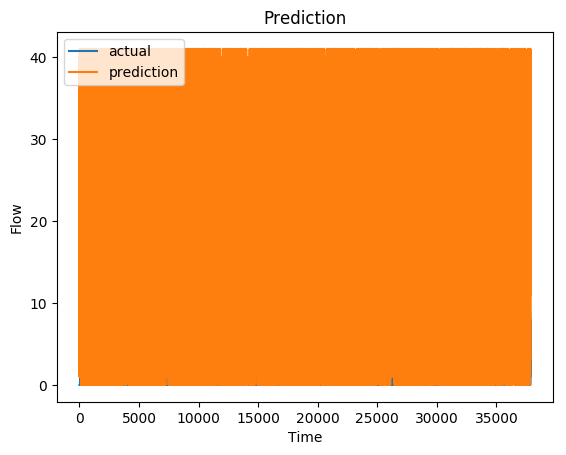

In [109]:
results['Random'] = random_guess(Y)

(1/8) (0.13499855995178223s) - RMSE: 5.873272341275489, NRMSE: 0.6826003680927507, MAE: 4.340151041666666
(2/8) (0.11930561065673828s) - RMSE: 5.559875492741872, NRMSE: 0.6763498231369617, MAE: 4.045046875
(3/8) (0.12677359580993652s) - RMSE: 5.660180563411089, NRMSE: 0.6852613283932895, MAE: 4.088989583333333
(4/8) (0.12175440788269043s) - RMSE: 6.953568422190388, NRMSE: 0.7450306123979972, MAE: 5.120666666666667
(5/8) (0.12450742721557617s) - RMSE: 6.603960774918842, NRMSE: 0.723300518784086, MAE: 4.816395833333333
(6/8) (0.11684870719909668s) - RMSE: 6.782178095091699, NRMSE: 0.7517420252125082, MAE: 5.0431510416666665
(7/8) (0.11635875701904297s) - RMSE: 6.708427952878255, NRMSE: 0.7636579961417306, MAE: 5.017723958333333
(8/8) (0.0012202262878417969s) - RMSE: 4.506082490563695, NRMSE: 1.1070338747575748, MAE: 3.8343137254901962


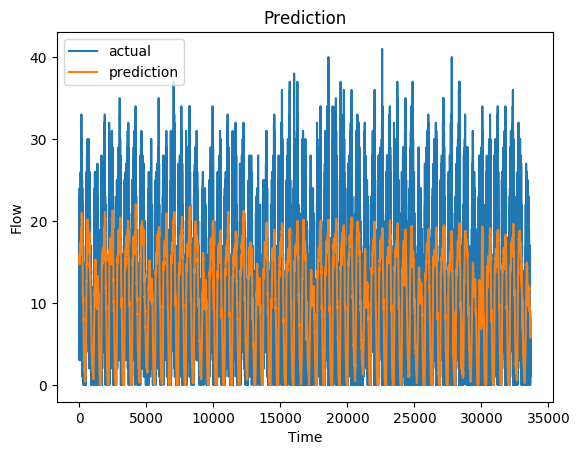

In [99]:
results['Mean'] = default_mean(X, Y)

(1/8) (29.50126814842224s) - RMSE: 3.8814190392433914, NRMSE: 0.4511042415469485, MAE: 2.7903280950662914
(2/8) (29.91848921775818s) - RMSE: 3.6049422099728736, NRMSE: 0.4385353645629415, MAE: 2.602285374232462
(3/8) (30.095712423324585s) - RMSE: 3.733160696327631, NRMSE: 0.45196272967119, MAE: 2.6362229798902206
(4/8) (29.987712144851685s) - RMSE: 5.968048285021493, NRMSE: 0.6394384003500985, MAE: 4.171850814752978
(5/8) (30.90655016899109s) - RMSE: 4.4170483746634845, NRMSE: 0.4837783702505054, MAE: 2.986569475678816
(6/8) (30.920006275177002s) - RMSE: 4.192788497357899, NRMSE: 0.46473201854911195, MAE: 2.899366010475765
(7/8) (30.974830150604248s) - RMSE: 4.2311934844177035, NRMSE: 0.4816604963629412, MAE: 2.8729617593900674
(8/8) (31.433559894561768s) - RMSE: 4.217470201668387, NRMSE: 1.0361289188124705, MAE: 3.3756862745098046


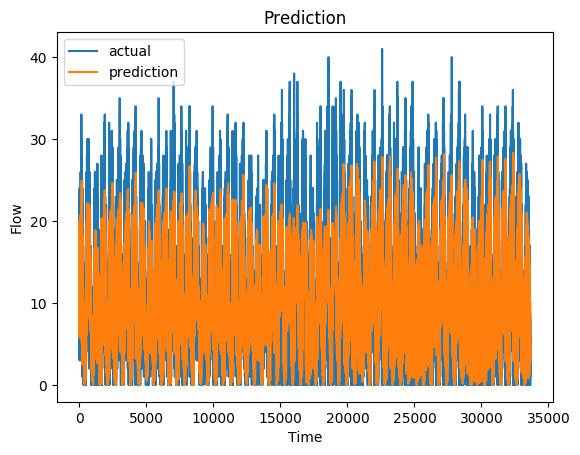

In [102]:
results['RF'] = random_forest(X, Y)

In [0]:
results['SVM'] = support_vector_machine(X, Y)

(1/8) (27.757118463516235s) - RMSE: 3.9938499804198235, NRMSE: 0.46417113124193243, MAE: 2.895752515299246
(2/8) (24.995370149612427s) - RMSE: 3.844521930353449, NRMSE: 0.4676798484130096, MAE: 2.8041477126007277
(3/8) (25.473186492919922s) - RMSE: 3.79946732777331, NRMSE: 0.45999027752707816, MAE: 2.6834787396589914
(4/8) (26.264623880386353s) - RMSE: 5.378074466176721, NRMSE: 0.5762264595356515, MAE: 3.651467247676725
(5/8) (25.88602352142334s) - RMSE: 5.029097013350915, NRMSE: 0.550813156339033, MAE: 3.347909136923651
(6/8) (25.96835732460022s) - RMSE: 4.297259357481976, NRMSE: 0.4763116519447909, MAE: 2.9599442599837977
(7/8) (24.99871563911438s) - RMSE: 4.325577371470647, NRMSE: 0.4924047438321257, MAE: 2.9126780265321335
(8/8) (24.702224493026733s) - RMSE: 4.084204901249448, NRMSE: 1.0033889052413796, MAE: 3.222927520088121


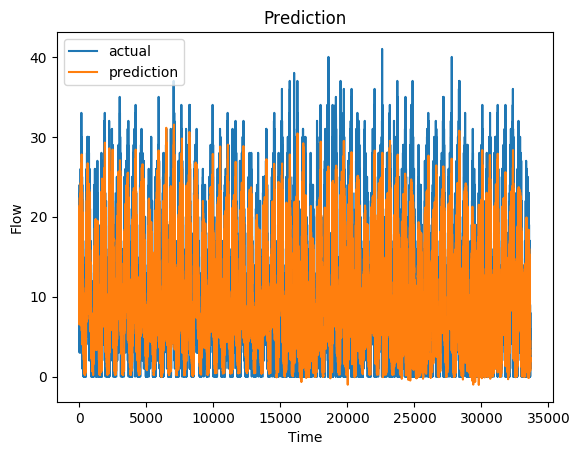

In [103]:
results['RNN'] = rnn(X, Y)

In [0]:
results['LSTM'] = lstm(X, Y)

In [0]:
results['GRU'] = gru(X, Y)

# Plot Functions

In [0]:
def plot_history (history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.figure(figsize=(100, 100))
  plt.show(name + "ind")
  plt.close('all')

In [0]:
def plot_prediction (Y, Y_hat):
  plt.plot(Y)
  plt.plot(Y_hat)
  plt.title('Prediction')
  plt.ylabel('Flow')
  plt.xlabel('Time')
  plt.legend(['actual', 'prediction'], loc='upper left')
  plt.rcdefaults()
  plt.show('Prediction')
  plt.close('all')

In [0]:
def plot_performance_bar(i, y_label, title):
  models = tuple(results.keys())
  y_pos = np.arange(len(models))
  print(results.values())
  performance = [v[i] for v in results.values()]

  plt.rcdefaults()
  plt.bar(y_pos, performance, align='center', alpha=0.5)
  plt.xticks(y_pos, models)
  plt.ylabel(y_label)
  plt.title(title)

  plt.show()

# Results Plots

dict_values([(0.07189464569091797, 18.27241616084441, 2.1146557530368355, 14.949313442651702), (0.8617672920227051, 6.080943266633915, 0.7668720683646122, 4.5383048406862745), (243.7381284236908, 4.280758848584108, 0.5559175675132759, 3.04190884799955), (206.0456199645996, 4.344006543534536, 0.5613732717593751, 3.0597881448454243)])


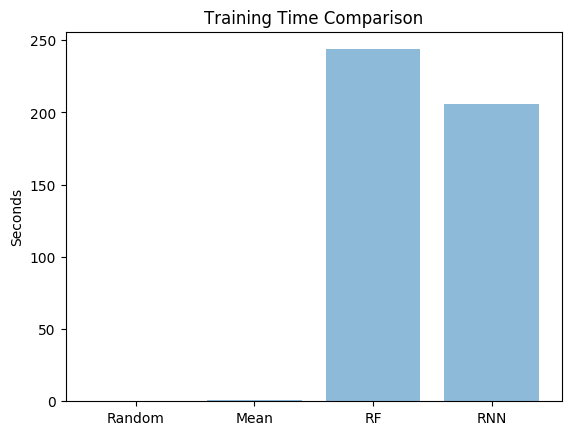

In [112]:
plot_performance_bar(0, 'Seconds', 'Training Time Comparison')

dict_values([(0.07189464569091797, 18.27241616084441, 2.1146557530368355, 14.949313442651702), (0.8617672920227051, 6.080943266633915, 0.7668720683646122, 4.5383048406862745), (243.7381284236908, 4.280758848584108, 0.5559175675132759, 3.04190884799955), (206.0456199645996, 4.344006543534536, 0.5613732717593751, 3.0597881448454243)])


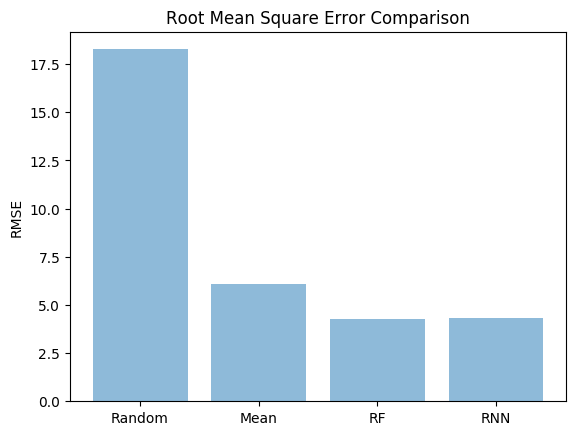

In [113]:
plot_performance_bar(1, 'RMSE', 'Root Mean Square Error Comparison')

In [0]:
plot_performance_bar(2, 'NRMSE', 'Normalized Root Mean Square Error Comparison')

In [0]:
plot_performance_bar(3, 'MAE', 'Max Absolute Error Comparison')

# Observations:

+ For the evaluation of the RNN and it's variations was used the Walking Forward methodology so that we had many test sessions and all training sessions where the same size [[1]](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9)